# Chicago TNP Data Exploration

Notes:

- Datasets to updated quarterly
- Starting and ending time rounded to nearest 15 minutes
- Trip fare rounded to nearest $2.50
- Tip rounded to nearest \$1.00

In [2]:
import json
import pandas as pd
import numpy as np
import requests
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from shapely.geometry import shape, Point

In [2]:
d = {'dataset_name': ['Trips', 'Drivers', 'Vehicles'], 'total_obs': [17432011, 4812612, 4812049], 'date_reported_start': ['11/01/2018', '2015-02','2015-02'], 'date_reported_end': ['12/31/2018', '2018-12', '2018-12'], 'num_cols': [21, 7, 9]}
summary_df = pd.DataFrame(d)
summary_df

dataset_name  total_obs date_reported_start date_reported_end  num_cols
0        Trips   17432011          11/01/2018        12/31/2018        21
1      Drivers    4812612             2015-02           2018-12         7
2     Vehicles    4812049             2015-02           2018-12         9

# Trips Dataset

API to get entries from midnight 11/21/2018 to midnight 11/22/2018 & make pandas df

In [27]:
os = 0
params = {'$limit': 1000, '$offset': os}
response = requests.get('https://data.cityofchicago.org/resource/m6dm-c72p.json?$where=trip_start_timestamp%20between%20%272018-11-21T00:00:00.000%27%20and%20%272018-11-22T00:00:00.000%27', params).json()
total_response = response
os = 1000
while len(response) >= 1000:
    params = {'$limit': 1000, '$offset': os}
    response = requests.get('https://data.cityofchicago.org/resource/m6dm-c72p.json?$where=trip_start_timestamp%20between%20%272018-11-21T00:00:00.000%27%20and%20%272018-11-22T00:00:00.000%27', params).json()
    os += 1000
    total_response += response

In [28]:
trips_df = pd.DataFrame.from_dict(total_response, dtype=str)

Line below is to write out/save json file as to avoid calling requests & waiting for API when reopening notebook:

In [43]:
with open("trips.json", "w") as write_file:
    json.dump(total_response, write_file)

In [3]:
trips_df = pd.read_json('trips.json')

In [4]:
trips_df.shape

(282375, 21)

In [18]:
trips_df.columns

Index(['additional_charges', 'dropoff_census_tract',
       'dropoff_centroid_latitude', 'dropoff_centroid_location',
       'dropoff_centroid_longitude', 'dropoff_community_area', 'fare',
       'pickup_census_tract', 'pickup_centroid_latitude',
       'pickup_centroid_location', 'pickup_centroid_longitude',
       'pickup_community_area', 'shared_trip_authorized', 'tip',
       'trip_end_timestamp', 'trip_id', 'trip_miles', 'trip_seconds',
       'trip_start_timestamp', 'trip_total', 'trips_pooled'],
      dtype='object')

In [9]:
trips_df.dtypes

additional_charges            float64
dropoff_census_tract          float64
dropoff_centroid_latitude     float64
dropoff_centroid_location      object
dropoff_centroid_longitude    float64
dropoff_community_area        float64
fare                          float64
pickup_census_tract           float64
pickup_centroid_latitude      float64
pickup_centroid_location       object
pickup_centroid_longitude     float64
pickup_community_area         float64
shared_trip_authorized           bool
tip                             int64
trip_end_timestamp             object
trip_id                        object
trip_miles                    float64
trip_seconds                    int64
trip_start_timestamp           object
trip_total                    float64
trips_pooled                    int64
dtype: object

See first five observations in dataset

In [10]:
trips_df.head(n=5)

additional_charges  dropoff_census_tract  dropoff_centroid_latitude  \
0                2.50                   NaN                  41.839087   
1                9.33                   NaN                        NaN   
2                2.50                   NaN                        NaN   
3                8.25                   NaN                        NaN   
4                2.50                   NaN                        NaN   

                           dropoff_centroid_location  \
0  {'type': 'Point', 'coordinates': [-87.71400380...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

   dropoff_centroid_longitude  dropoff_community_area  fare  \
0                  -87.714004                    30.0   7.5   
1                         NaN                     NaN  20.0   
2                         NaN                     NaN  25.0   
3                         NaN                     NaN  20.0   
4                         NaN                     NaN  27.5   

   pickup_census_tract  pickup_centroid_latitude  \
0                  NaN                       NaN   
1                  NaN                 41.980264   
2                  NaN                 41.874005   
3         1.703198e+10                 41.785999   
4                  NaN                 41.829922   

                            pickup_centroid_location  ...  \
0                                                NaN  ...   
1  {'type': 'Point', 'coordinates': [-87.91362459...  ...   
2  {'type': 'Point', 'coordinates': [-87.66351754...  ...   
3  {'type': 'Point', 'coordinates': [-87.75093428...  ...   
4  {'type': 'Point', 'coordinates': [-87.67250264...  ...   

   pickup_community_area  shared_trip_authorized  tip  \
0                    NaN                   False    0   
1                   76.0                   False    0   
2                   28.0                   False    5   
3                   56.0                   False    0   
4                   59.0                   False    0   

        trip_end_timestamp                                   trip_id  \
0  2018-11-21T00:00:00.000  10e6be997137b6df0d9aa2860de49afa5aa21e65   
1  2018-11-21T00:45:00.000  16e971b8155f0a3f7fab5eddadacdc1d85c6b62b   
2  2018-11-21T00:45:00.000  1815220901f6074659600af59d932be10852f5d5   
3  2018-11-21T00:30:00.000  31f6cad79703c15b04fccfd316447d4f554dd571   
4  2018-11-21T00:30:00.000  77c6f283dd958c8259218d60b986c20343db20a1   

  trip_miles  trip_seconds     trip_start_timestamp trip_total  trips_pooled  
0   3.918728           592  2018-11-21T00:00:00.000      10.00             1  
1  12.802679          2196  2018-11-21T00:00:00.000      29.33             1  
2  10.361085          3022  2018-11-21T00:00:00.000      32.50             1  
3  13.438683          1396  2018-11-21T00:00:00.000      28.25             1  
4  23.360575          1714  2018-11-21T00:00:00.000      30.00             1  

[5 rows x 21 columns]

Number of NaN/Null Values by Column

In [11]:
trips_df.isnull().sum(axis=0)

additional_charges                0
dropoff_census_tract          88860
dropoff_centroid_latitude     18310
dropoff_centroid_location     18310
dropoff_centroid_longitude    18310
dropoff_community_area        18491
fare                              0
pickup_census_tract           89732
pickup_centroid_latitude      18828
pickup_centroid_location      18828
pickup_centroid_longitude     18828
pickup_community_area         18935
shared_trip_authorized            0
tip                               0
trip_end_timestamp                0
trip_id                           0
trip_miles                        0
trip_seconds                      0
trip_start_timestamp              0
trip_total                        0
trips_pooled                      0
dtype: int64

For longest value in each column:

In [42]:
longest_val = 0
for column in trips_df.columns:
    for val in trips_df[column].unique():
        if len(str(val)) > longest_val:
            longest_val = len(str(val))
    print(column, longest_val)

additional_charges 5
dropoff_census_tract 11
dropoff_centroid_latitude 13
dropoff_centroid_location 70
dropoff_centroid_longitude 70
dropoff_community_area 70
fare 70
pickup_census_tract 70
pickup_centroid_latitude 70
pickup_centroid_location 70
pickup_centroid_longitude 70
pickup_community_area 70
shared_trip_authorized 70
tip 70
trip_end_timestamp 70
trip_id 70
trip_miles 70
trip_seconds 70
trip_start_timestamp 70
trip_total 70
trips_pooled 70


Converts timestamps from strings to datetime objects

In [5]:
trips_df['trip_start_timestamp'] = pd.to_datetime(trips_df['trip_start_timestamp'])
trips_df['trip_end_timestamp'] = pd.to_datetime(trips_df['trip_end_timestamp'])

Earliest trip start time for obs in df:

In [33]:
trips_df.trip_start_timestamp.min()

Timestamp('2018-11-21 00:00:00')

Latest trip start time for obs in df:

In [34]:
trips_df.trip_start_timestamp.max()

Timestamp('2018-11-22 00:00:00')

Earliest trip end time for obs in df:

In [35]:
trips_df.trip_end_timestamp.min()

Timestamp('2018-11-21 00:00:00')

Latest trip end time for obs in df:

In [36]:
trips_df.trip_end_timestamp.max()

Timestamp('2018-11-22 05:45:00')

Total Trip Fares Compared w/ Trip Start Time

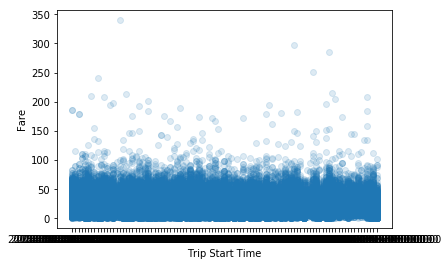

In [79]:
plt.scatter(x=trips_df['trip_start_timestamp'], y=trips_df['trip_total'], alpha=0.15)
plt.xlabel('Trip Start Time')
plt.ylabel('Fare')
plt.show()

Length (Time) of Trip vs. Total Trip Fare

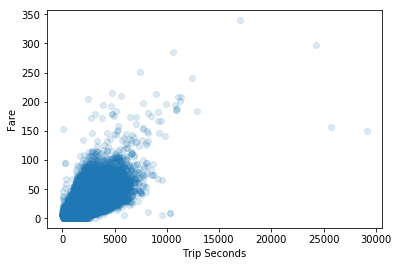

In [80]:
plt.scatter(x=trips_df['trip_seconds'], y=trips_df['trip_total'], alpha=0.15)
plt.xlabel('Trip Seconds')
plt.ylabel('Fare')
plt.show()

Price by Miles Traveled

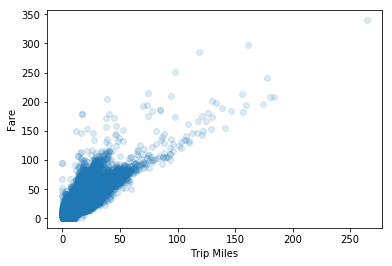

In [38]:
plt.scatter(x=trips_df['trip_miles'], y=trips_df['trip_total'], alpha=0.15)
plt.xlabel('Trip Miles')
plt.ylabel('Fare')
plt.show()

Below Plots the Fares vs. Pick Up Times For Pooled vs. Not Pooled Rides (True = Pooled; False = Not Pooled)

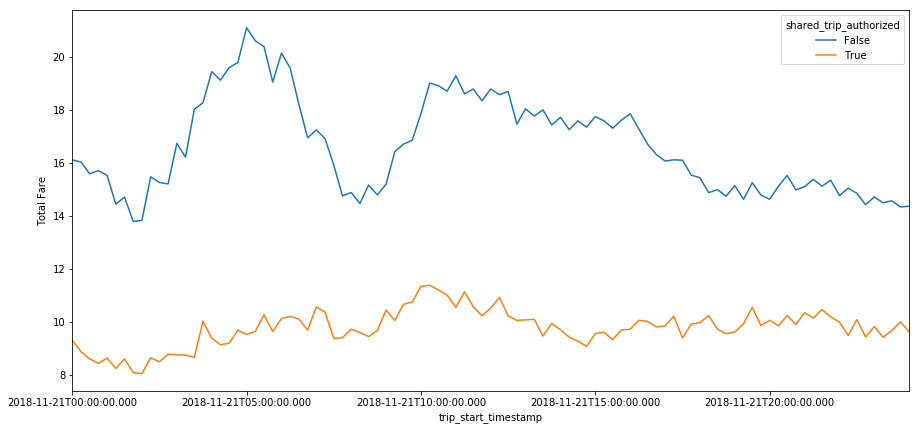

In [83]:
fig, ax = plt.subplots(figsize=(15,7))
plt.ylabel('Total Fare')
trips_df.groupby(['trip_start_timestamp', 'shared_trip_authorized']).mean()['trip_total'].unstack().plot(ax=ax)

# Rush vs. Non-rush Analysis

Early Morning (00:00:00 to 6:30:00)

In [67]:
early_morning_df = trips_df[trips_df['trip_start_timestamp'] <= '2018-11-21 06:30:00']

Morning Rush (6:30:01 to 10:00:00)

In [73]:
morning_rush_df = trips_df[(trips_df['trip_start_timestamp'] > '2018-11-21 06:30:01') & (trips_df['trip_start_timestamp'] <= '2018-11-21 10:00:00')]

Morning Rush Heatmaps (w/ null locations dropped)

In [69]:
morning_rush_df = morning_rush_df[morning_rush_df['pickup_centroid_latitude'].notnull()]
morning_rush_df = morning_rush_df[morning_rush_df['dropoff_centroid_latitude'].notnull()]

Morning Rush Pickups Heatmap

In [70]:
xy = morning_rush_df[['pickup_centroid_latitude', 'pickup_centroid_longitude']]
hmap = folium.Map(location=[41.87, -87.69], zoom_start=11)
hm_rod = HeatMap(list(zip(xy['pickup_centroid_latitude'].values, xy['pickup_centroid_longitude'].values)), radius=13, blur=20)
hmap.add_child(hm_rod)

Morning Rush Dropoffs Heatmap

In [71]:
xy = morning_rush_df[['dropoff_centroid_latitude', 'dropoff_centroid_longitude']]
hmap = folium.Map(location=[41.87, -87.69], zoom_start=11)
hm_rod = HeatMap(list(zip(xy['dropoff_centroid_latitude'].values, xy['dropoff_centroid_longitude'].values)), radius=12, blur=20)
hmap.add_child(hm_rod)

Midday (10:00:001 to 16:00:00)

In [74]:
midday_df = trips_df[(trips_df['trip_start_timestamp'] > '2018-11-21 10:00:01') & (trips_df['trip_start_timestamp'] <= '2018-11-21 16:00:00')]

Evening Rush (16:00:01 to 19:00:00)

In [76]:
evening_rush_df = trips_df[(trips_df['trip_start_timestamp'] > '2018-11-21 16:00:01') & (trips_df['trip_start_timestamp'] <= '2018-11-21 19:00:00')]

Evening Rush Pickups Heatmap

In [77]:
evening_rush_df = evening_rush_df[evening_rush_df['pickup_centroid_latitude'].notnull()]
evening_rush_df = evening_rush_df[evening_rush_df['dropoff_centroid_latitude'].notnull()]
xy = evening_rush_df[['pickup_centroid_latitude', 'pickup_centroid_longitude']]
hmap = folium.Map(location=[41.87, -87.69], zoom_start=11)
hm_rod = HeatMap(list(zip(xy['pickup_centroid_latitude'].values, xy['pickup_centroid_longitude'].values)), radius=13, blur=20)
hmap.add_child(hm_rod)

Evening Rush Dropoffs Heatmap

In [78]:
xy = evening_rush_df[['dropoff_centroid_latitude', 'dropoff_centroid_longitude']]
hmap = folium.Map(location=[41.87, -87.69], zoom_start=11)
hm_rod = HeatMap(list(zip(xy['dropoff_centroid_latitude'].values, xy['dropoff_centroid_longitude'].values)), radius=13, blur=20)
hmap.add_child(hm_rod)

Late Evening (19:00:01 to 11:59:59)

In [79]:
late_even_df = trips_df[(trips_df['trip_start_timestamp'] > '2018-11-21 19:00:01') & (trips_df['trip_start_timestamp'] <= '2018-11-21 11:59:59')]

## Analysis by Sides of City (North/West/South/Central)

Cleaned and created new dataframe with only observations that have a value in 'pickup_community_area' column

In [5]:
trips_w_pickup_areas = trips_df[trips_df['pickup_community_area'].notnull()]
trips_w_pickup_areas['pickup_community_area'] = trips_w_pickup_areas['pickup_community_area'].astype(int).astype(str)

C:\Users\KKoenig\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In the following analysis, I slotted each of the 77 community areas in their respective "sides" of the city (Central, North, South, West) because Chicago is very divided along these lines in terms of race, income, resources, etc.

For the zones/demarcation I used in this analysis of North/Central/South/West sides: https://www.kaggle.com/mcnutt/chicagocommunityareas

In [6]:
sides_df = pd.read_csv('community-areas.csv').drop(columns = 'Unnamed: 2')
sides_df['community_area'] = sides_df['id']
sides_df = sides_df.astype(str)
sides_df['pickup_community_area'] = sides_df['community_area']

In [7]:
pickups_w_sides = pd.merge(trips_w_pickup_areas, sides_df[['pickup_community_area', 'zone']], on=['pickup_community_area'])

Plot of Mean Fare Totals for Pickups by Time by Sides of City

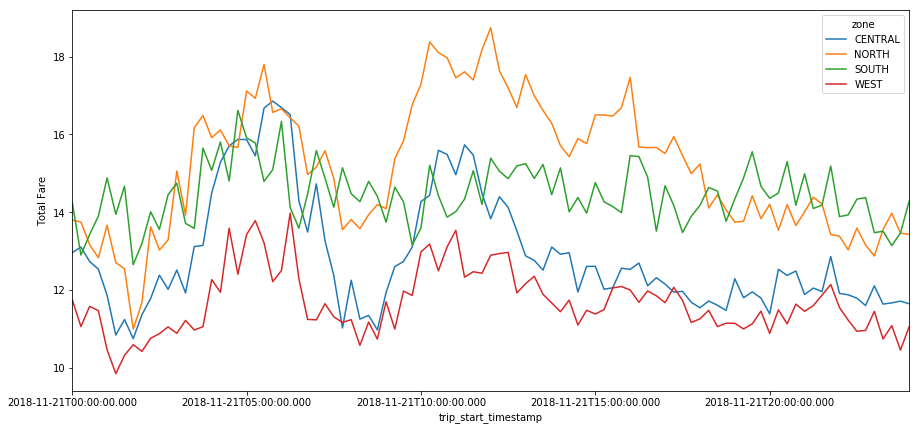

In [84]:
fig, ax = plt.subplots(figsize=(15,7))
plt.ylabel('Total Fare')
pickups_w_sides.groupby(['trip_start_timestamp', 'zone']).mean()['trip_total'].unstack().plot(ax=ax)

Mean Fare Totals for Pickups By Sides of City for Pooled Rides

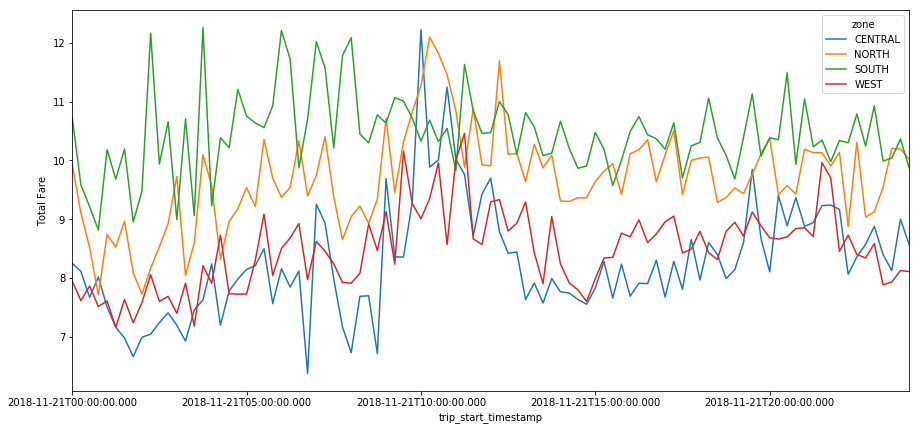

In [27]:
mask = pickups_w_sides['shared_trip_authorized'] == True
fig, ax = plt.subplots(figsize=(15,7))
plt.ylabel('Total Fare')
pickups_w_sides[mask].groupby(['trip_start_timestamp', 'zone']).mean()['trip_total'].unstack().plot(ax=ax)

Mean Fare Totals for Pickups By Sides of City for Not Pooled Rides

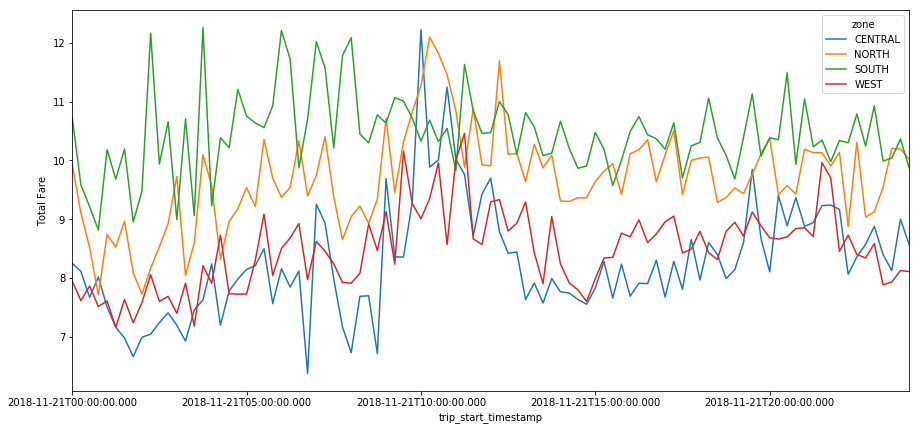

In [35]:
mask = pickups_w_sides['shared_trip_authorized'] == True
fig, ax = plt.subplots(figsize=(15,7))
plt.ylabel('Total Fare')
pickups_w_sides[mask].groupby(['trip_start_timestamp', 'zone']).mean()['trip_total'].unstack().plot(ax=ax)

Number of Pickups in Each Zone

In [132]:
pickups_w_sides.groupby('zone')['trip_id'].count()

zone
CENTRAL    69773
NORTH      91511
SOUTH      44399
WEST       57757
Name: trip_id, dtype: int64

In [8]:
sides_df['dropoff_community_area'] = sides_df['community_area']

In [9]:
trips_w_dropoff_areas = trips_df[trips_df['dropoff_community_area'].notnull()]

In [10]:
trips_w_dropoff_areas['dropoff_community_area'] = trips_w_dropoff_areas['dropoff_community_area'].astype(int).astype(str)

C:\Users\KKoenig\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
dropoffs_w_sides = pd.merge(trips_w_dropoff_areas, sides_df[['dropoff_community_area', 'zone']], on=['dropoff_community_area'])

Plot of Mean Fare Totals for Dropoffs by Time by Sides of City

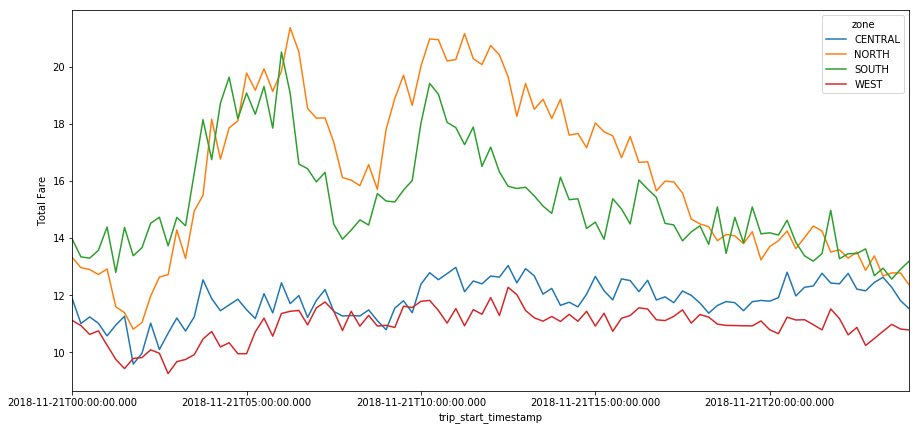

In [100]:
fig, ax = plt.subplots(figsize=(15,7))
plt.ylabel('Total Fare')
dropoffs_w_sides.groupby(['trip_start_timestamp', 'zone']).mean()['trip_total'].unstack().plot(ax=ax)

Total Fares for Dropoffs in Different Sides of the City for Pooled Rides Only

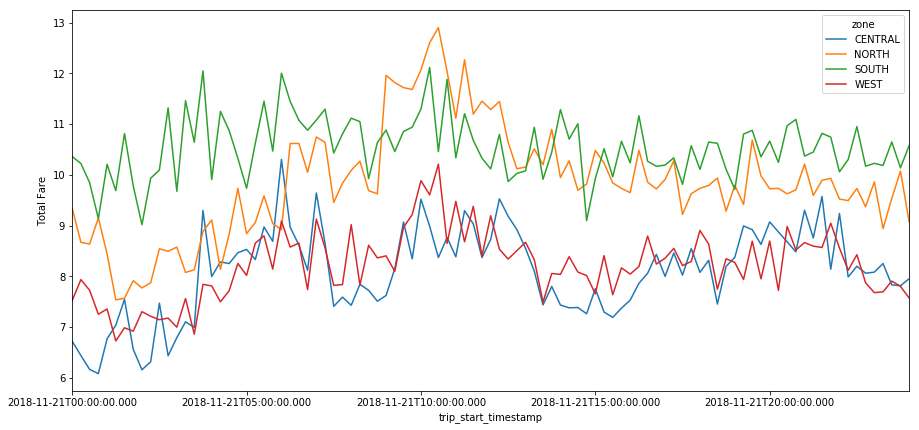

In [39]:
mask = dropoffs_w_sides['shared_trip_authorized'] == True
fig, ax = plt.subplots(figsize=(15,7))
plt.ylabel('Total Fare')
dropoffs_w_sides[mask].groupby(['trip_start_timestamp', 'zone']).mean()['trip_total'].unstack().plot(ax=ax)

Total Fares for Dropoffs in Different Sides of the City for Unpooled Rides Only

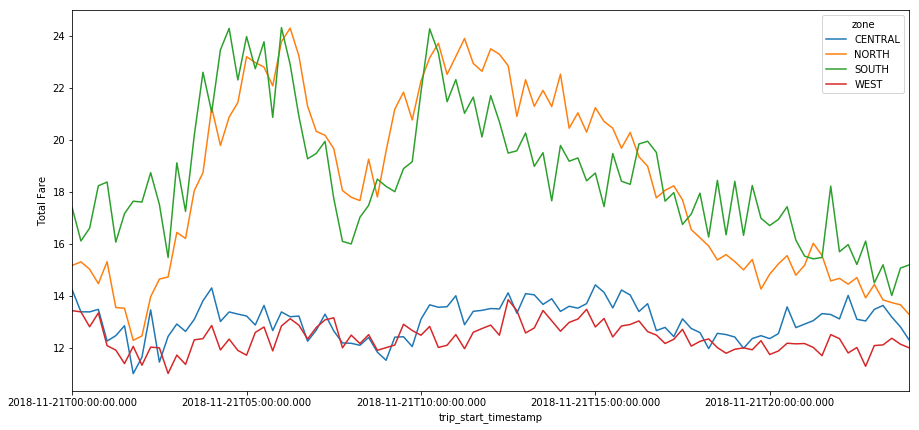

In [40]:
mask = dropoffs_w_sides['shared_trip_authorized'] == False
fig, ax = plt.subplots(figsize=(15,7))
plt.ylabel('Total Fare')
dropoffs_w_sides[mask].groupby(['trip_start_timestamp', 'zone']).mean()['trip_total'].unstack().plot(ax=ax)

Number of Dropoffs in Each Zone

In [130]:
dropoffs_w_sides.groupby('zone')['trip_id'].count()

zone
CENTRAL    69075
NORTH      91470
SOUTH      44609
WEST       58730
Name: trip_id, dtype: int64

Below is code to compare pickup zone and dropoff zone:

In [12]:
dropoffs_w_sides['dropoff_zone'] = dropoffs_w_sides['zone']
pickups_w_sides['pickup_zone'] = pickups_w_sides['zone']

In [13]:
merged = pd.merge(pickups_w_sides[['trip_id', 'pickup_community_area', 'pickup_zone', 'trip_total', 'fare', 'tip', 'trip_miles', 'shared_trip_authorized']], dropoffs_w_sides[['trip_id', 'dropoff_community_area', 'dropoff_zone']], on='trip_id')

In [159]:
merged.shape

(260614, 10)

Percentage of Trips that Cross Zones

In [163]:
100 * merged[merged['pickup_zone'] != merged['dropoff_zone']].shape[0] / merged.shape[0]

48.20385704528537

Breakdown Pickup/Dropff Zones as Percentage of Trips

In [25]:
for pickup in merged['pickup_zone'].unique():
    for dropoff in merged['dropoff_zone'].unique():
        print("Pickup: " + pickup + "; Dropoff: " + dropoff)
        percent = 100 * merged[(merged['pickup_zone'] == pickup) & (merged['dropoff_zone'] == dropoff)].shape[0] / merged.shape[0]
        print(percent)
        print()

Pickup: NORTH; Dropoff: NORTH
20.91445586192607

Pickup: NORTH; Dropoff: WEST
4.998196566569717

Pickup: NORTH; Dropoff: CENTRAL
6.676540784455171

Pickup: NORTH; Dropoff: SOUTH
1.1484417567743865

Pickup: WEST; Dropoff: NORTH
4.837806104046598

Pickup: WEST; Dropoff: WEST
9.042491961291411

Pickup: WEST; Dropoff: CENTRAL
6.476628270162002

Pickup: WEST; Dropoff: SOUTH
2.0750995725479062

Pickup: SOUTH; Dropoff: NORTH
1.0072367562755646

Pickup: SOUTH; Dropoff: WEST
2.0248336620442493

Pickup: SOUTH; Dropoff: CENTRAL
2.6226526587213272

Pickup: SOUTH; Dropoff: SOUTH
10.554306368805973

Pickup: CENTRAL; Dropoff: NORTH
6.7805259886268585

Pickup: CENTRAL; Dropoff: WEST
6.873767334064939

Pickup: CENTRAL; Dropoff: CENTRAL
11.284888762691184

Pickup: CENTRAL; Dropoff: SOUTH
2.682127590996646



## Census Tract

Census tract data from City of Chicago Data Portal (clean and make geodataframe:

In [6]:
r = requests.get('https://data.cityofchicago.org/resource/74p9-q2aq.json')
tract_data = r.json()
for d in tract_data:
    d['geometry'] = shape(d['the_geom'])
tracts_gdf = gpd.GeoDataFrame(tract_data).set_geometry('geometry')
tracts_gdf['tract'] = tracts_gdf['tractce10']

Clean rides data to make geodataframe for rides w/ pickup location data:

In [7]:
rides_w_pickups = trips_df[trips_df['pickup_centroid_latitude'].notnull()]
rides_w_pickups['geometry'] = list(zip(rides_w_pickups.pickup_centroid_longitude, rides_w_pickups.pickup_centroid_latitude))
rides_w_pickups['geometry'] = rides_w_pickups['geometry'].apply(Point)
points_gdf = gpd.GeoDataFrame(rides_w_pickups, geometry='geometry')

C:\Users\KKoenig\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\KKoenig\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Merge Census Tract GDF w/ Cleaned Pickups GDF

In [8]:
pickups_w_tract = gpd.sjoin(points_gdf, tracts_gdf[['tract','geometry']], how="left", op='intersects')

In [9]:
pickups_w_tract['pickup_census_tract'] = pickups_w_tract['tract']
pickups_w_tract.drop(columns=['tract', 'dropoff_census_tract'], inplace=True)

Add Column of Fare + Additional Charges (No Tip Included)

In [58]:
pickups_w_tract['fare_w_addl'] = pickups_w_tract['fare'] + pickups_w_tract['additional_charges']

Average Price by Pickup Census Tract

In [59]:
pickups_w_tract.groupby('pickup_census_tract').mean()['fare_w_addl'].sort_values(ascending=False)

pickup_census_tract
421200    102.800000
770602     41.500000
980000     36.376554
980100     34.595268
491200     30.000000
420300     25.951071
612000     25.000000
671600     24.375000
411100     24.072131
460301     22.500000
530503     22.300000
010503     21.410467
010400     21.341516
030104     21.206625
730100     20.625000
836200     20.538216
560800     20.352517
460700     20.200000
410600     20.190741
670400     20.150000
170600     20.075000
490700     20.000000
500300     20.000000
640100     19.778182
251600     19.444444
440700     19.000000
010502     18.993333
030103     18.949783
810400     18.360000
410700     18.194915
             ...    
570500      9.700000
420800      9.671061
580300      9.642857
243400      9.550449
834500      9.500000
740100      9.472727
351100      9.458333
271400      9.285714
835600      9.274258
660700      9.273000
680600      8.750000
611000      8.750000
260600      8.750000
671800      8.750000
280900      8.468679
261000      8.

Census Tracts with Average Fare, Average Milage, Fare/Mile

In [60]:
pickup_census_grouped = pickups_w_tract.groupby('pickup_census_tract')[['fare_w_addl', 'trip_miles']].mean().reset_index()

In [98]:
pickup_census_grouped['fare_per_mile'] = pickup_census_grouped['fare_w_addl'] / pickup_census_grouped['trip_miles']
pickup_census_grouped

pickup_census_tract  fare_w_addl  trip_miles  fare_per_mile
0                010100    14.100286    6.637110       2.124462
1                010201    12.610000    6.330307       1.992004
2                010202    10.241990    4.348614       2.355231
3                010300    14.928300    6.881309       2.169398
4                010400    21.341516    9.941072       2.146802
5                010501    16.803306    7.851852       2.140044
6                010502    18.993333    9.356120       2.030044
7                010503    21.410467   10.433625       2.052064
8                010600    15.218408    6.684537       2.276659
9                010701    13.500000    6.703698       2.013814
10               010702    12.978118    5.866418       2.212273
11               020100    13.088235    5.950627       2.199472
12               020200    11.917802    5.169510       2.305403
13               020301    13.387222    6.266391       2.136353
14               020302    12.354423    6.106059       2.023305
15               020400    14.215156    6.951525       2.044897
16               020500    12.589769    6.146381       2.048322
17               020601    14.422778    7.328818       1.967954
18               020602    12.046504    5.310299       2.268517
19               020701    12.330000    5.906449       2.087549
20               020702    12.973267    6.033017       2.150378
21               020801    12.663898    5.830962       2.171837
22               020802    13.125810    6.846587       1.917132
23               020901    11.301892    5.769046       1.959057
24               020902    12.487130    5.685085       2.196472
25               030101    13.280577    5.940434       2.235624
26               030102    16.107009    7.789577       2.067764
27               030103    18.949783    9.528325       1.988784
28               030104    21.206625   10.314949       2.055912
29               030200    15.587822    6.979119       2.233494
..                  ...          ...         ...            ...
730              841000    15.407606    6.195349       2.486963
731              841100    11.534376    4.461420       2.585360
732              841200    11.163860    5.030781       2.219111
733              841300    11.766654    5.572544       2.111541
734              841400    12.321429    5.977718       2.061226
735              841500    11.287879    5.759208       1.959971
736              841700    11.250000    5.654437       1.989588
737              841800    12.607692    7.213419       1.747811
738              841900    10.609403    4.412471       2.404413
739              842000    13.201451    6.489421       2.034303
740              842100    12.370978    5.781178       2.139872
741              842200    10.598273    3.651489       2.902452
742              842300    10.218655    3.361949       3.039503
743              842400    11.047010    4.603762       2.399562
744              842500    11.785714    4.645093       2.537240
745              842600    11.763736    5.742353       2.048591
746              842800    12.284667    6.085809       2.018576
747              842900    11.204787    4.871008       2.300302
748              843000    11.435357    5.435146       2.103965
749              843100    12.173824    5.321706       2.287579
750              843200    11.133222    5.120874       2.174086
751              843300    11.784423    5.708876       2.064228
752              843400    11.000000    6.663121       1.650878
753              843500    12.200000    5.437373       2.243730
754              843600    11.233766    5.520240       2.035014
755              843700    12.388432    4.619119       2.681991
756              843800    14.166667    7.296730       1.941509
757              843900    14.342871    7.998088       1.793288
758              980000    36.376554   18.964770       1.918112
759              980100    34.595268   17.724798       1.951800

[760 rows x 4 columns]

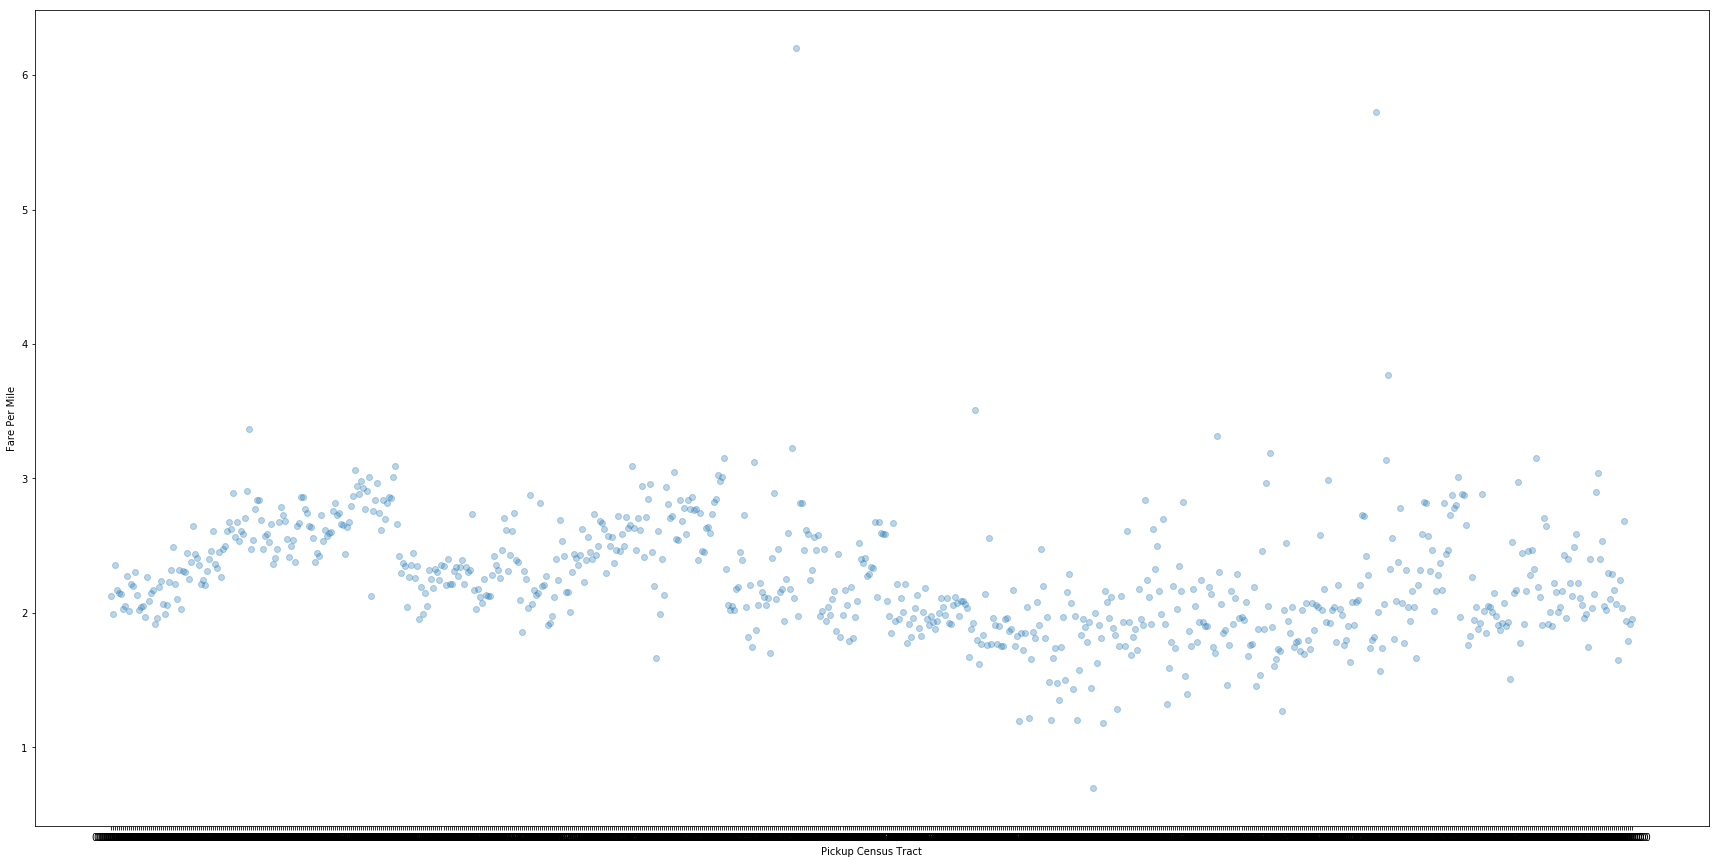

In [86]:
plt.scatter(x=pickup_census_grouped['pickup_census_tract'], y=pickup_census_grouped['fare_per_mile'], alpha=0.30)
plt.xlabel('Pickup Census Tract')
plt.ylabel('Fare Per Mile')
plt.show()

Average Fare Per Mile Across Groups

In [65]:
total_mean = pickup_census_grouped.fare_per_mile.mean()
total_mean

2.2543404933557674

Standard Deviation for Fare per Mile for All Pickup Census Tracts

In [66]:
std_dev = pickup_census_grouped.fare_per_mile.std()
std_dev

0.43489722876961906

Pickup Census Tracts w/ Averages More than Two Standard Deviations from Total Mean

In [116]:
mask = (pickup_census_grouped['fare_per_mile'] > total_mean + 2*std_dev) | (pickup_census_grouped['fare_per_mile'] < total_mean - 2*std_dev)
pickup_tracts_outside_2_devs = pickup_census_grouped[mask]
pickup_tracts_outside_2_devs

pickup_census_tract  fare_w_addl  trip_miles  fare_per_mile
69               050800    10.180781    3.023908       3.366763
306              243500    10.530263    3.341103       3.151732
340              271300     5.000000    1.549210       3.227452
342              271500     7.500000    1.209297       6.201953
431              421200   102.800000   29.272851       3.511786
453              440800    10.000000    8.379491       1.193390
458              460301    22.500000   18.411572       1.222058
469              490300    10.833333    9.018095       1.201289
473              490800    14.264706   10.536501       1.353837
482              500300    20.000000   16.644433       1.201603
490              530600    12.500000   17.956260       0.696136
495              560200     8.333333    7.073386       1.178125
502              561100    13.571429   10.561310       1.285014
527              611000     8.750000    6.630835       1.319593
552              640600    10.833333    3.263911       3.319126
578              671300    10.000000    3.135109       3.189682
584              680600     8.750000    6.902025       1.267744
631              730300     6.875000    1.200917       5.724791
636              740100     9.472727    3.020336       3.136315
637              740200     8.039583    2.131445       3.771893
711              838300    10.944154    3.474064       3.150245

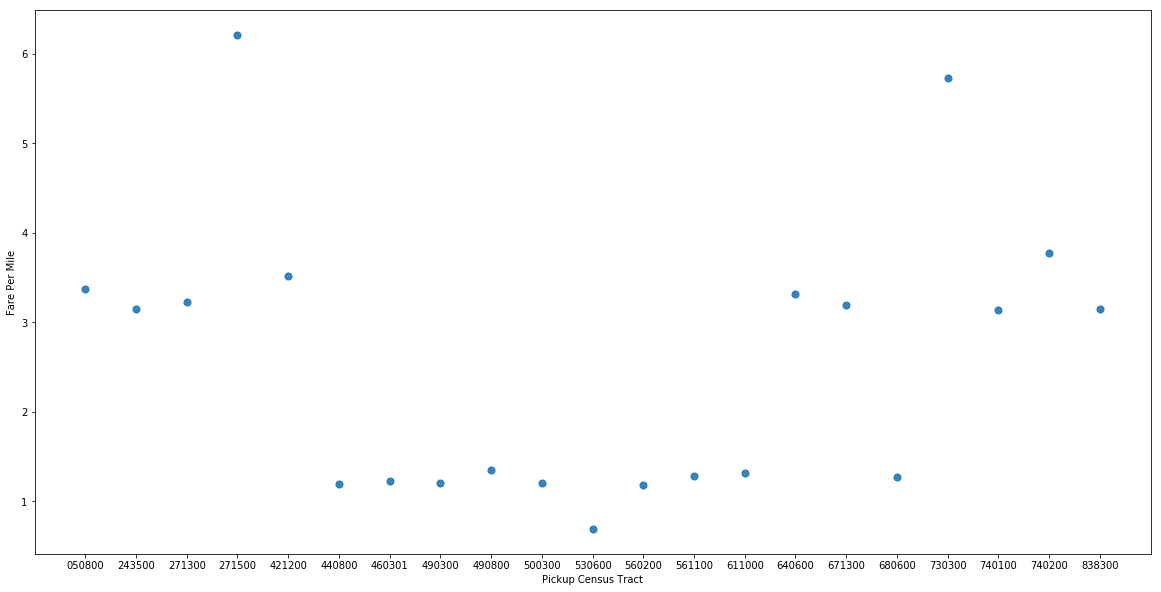

In [115]:
plt.scatter(x='pickup_census_tract', y='fare_per_mile', data=pickup_tracts_outside_2_devs, alpha=0.9, s=50)
plt.rcParams["figure.figsize"] = [20,10]
plt.xlabel('Pickup Census Tract')
plt.ylabel('Fare Per Mile')
plt.show()

Clean dropoffs in rides data to make geodataframe:

In [93]:
rides_w_dropoffs = trips_df[trips_df['dropoff_centroid_latitude'].notnull()]
rides_w_dropoffs['geometry'] = list(zip(rides_w_dropoffs.dropoff_centroid_longitude, rides_w_dropoffs.dropoff_centroid_latitude))
rides_w_dropoffs['geometry'] = rides_w_dropoffs['geometry'].apply(Point)
points_gdf = gpd.GeoDataFrame(rides_w_dropoffs, geometry='geometry')

C:\Users\KKoenig\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\KKoenig\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Merge Cleaned Dropoffs GDF w/ Census GDF to get census tract of each dropoff:

In [102]:
dropoffs_w_tract = gpd.sjoin(points_gdf, tracts_gdf[['tract','geometry']], how="left", op='intersects')

In [103]:
dropoffs_w_tract['dropoff_census_tract'] = dropoffs_w_tract['tract']
dropoffs_w_tract.drop(columns=['tract', 'pickup_census_tract'], inplace=True)

Add "fare_w_addl" -- the fare + any additional charges (tips not included)

In [104]:
dropoffs_w_tract['fare_w_addl'] = dropoffs_w_tract['fare'] + dropoffs_w_tract['additional_charges']

Dropoff Census Tracks by Fares (High -> Low)

In [105]:
dropoffs_w_tract.groupby('dropoff_census_tract').mean()['fare_w_addl'].sort_values(ascending=False)

dropoff_census_tract
980000    35.688816
580800    34.683333
980100    32.656199
750200    30.775000
640700    27.100000
681300    24.642857
251700    24.562500
460400    23.156000
560800    22.890007
170600    22.500000
670100    21.786667
530600    21.250000
660500    21.250000
640500    20.714286
740100    20.350000
222800    20.070000
560400    20.000000
720700    19.583333
835200    19.069375
640100    18.866667
510200    18.753333
560200    18.750000
560300    18.750000
840800    18.750000
834700    18.125000
720400    18.061429
490800    18.055556
490700    18.055556
661100    18.000000
550100    17.716591
            ...    
280800     9.000000
280900     8.998750
230200     8.977273
243400     8.941944
350400     8.809524
730700     8.750000
711300     8.750000
610800     8.750000
610400     8.750000
834800     8.750000
837000     8.699565
840100     8.691562
420700     8.645833
834500     8.417500
670300     8.340000
260200     8.333333
230400     8.333333
611500     8.208462

Dropoff Census Tracts with Fare Per Mile

In [106]:
dropoff_census_grouped = dropoffs_w_tract.groupby('dropoff_census_tract')[['fare_w_addl', 'trip_miles']].mean().reset_index()
dropoff_census_grouped['fare_per_mile'] = dropoff_census_grouped['fare_w_addl'] / dropoff_census_grouped['trip_miles']
dropoff_census_grouped

dropoff_census_tract  fare_w_addl  trip_miles  fare_per_mile
0                 010100    12.745779    6.119043       2.082969
1                 010201    11.182235    5.464868       2.046204
2                 010202    11.150376    4.855111       2.296626
3                 010300    12.950313    5.897704       2.195823
4                 010400    13.500119    6.390757       2.112445
5                 010501    12.972269    5.976106       2.170689
6                 010502    11.586117    5.344139       2.168004
7                 010503    12.978077    6.324396       2.052066
8                 010600    13.066436    6.077283       2.150046
9                 010701    10.722222    4.537635       2.362954
10                010702    11.799806    5.276310       2.236375
11                020100    11.497246    4.790907       2.399806
12                020200    14.656866    7.129528       2.055798
13                020301    14.390385    6.259544       2.298951
14                020302    13.112059    7.045798       1.860976
15                020400    13.361176    5.762591       2.318606
16                020500    11.615461    5.422526       2.142076
17                020601    10.769231    4.731932       2.275863
18                020602    11.263134    4.854662       2.320066
19                020701    12.416071    6.308909       1.968022
20                020702    12.201980    5.944350       2.052702
21                020801    11.965109    5.628611       2.125766
22                020802    12.034204    5.901250       2.039263
23                020901    10.789247    5.080772       2.123545
24                020902    10.795408    4.464450       2.418082
25                030101    11.413709    5.378047       2.122277
26                030102    11.817105    5.233101       2.258146
27                030103    12.458409    6.997843       1.780321
28                030104    14.687500    8.099107       1.813471
29                030200    12.260089    5.474677       2.239418
..                   ...          ...         ...            ...
730               841000    13.046997    5.325398       2.449957
731               841100    11.157426    4.285509       2.603524
732               841200    11.358955    5.334907       2.129176
733               841300    11.628504    5.692776       2.042677
734               841400    11.250000    4.825565       2.331333
735               841500    11.147429    4.589586       2.428853
736               841700    11.071429    7.740241       1.430373
737               841800    12.791579    6.141824       2.082700
738               841900    10.841467    4.468626       2.426130
739               842000    10.637403    4.889720       2.175462
740               842100    12.031029    5.863934       2.051699
741               842200     9.851376    3.273262       3.009651
742               842300     9.604581    3.066405       3.132196
743               842400    10.870495    4.708372       2.308758
744               842500    10.720000    6.084985       1.761713
745               842600    11.181597    5.326294       2.099320
746               842800    10.504286    4.722925       2.224106
747               842900     9.734826    3.698340       2.632215
748               843000    10.317460    4.456189       2.315311
749               843100    12.608000    6.193607       2.035647
750               843200    11.011673    5.128929       2.146973
751               843300    10.665238    4.971907       2.145100
752               843400    12.500000    6.409897       1.950109
753               843500    13.798302    7.244262       1.904722
754               843600    10.422308    5.054486       2.061992
755               843700    10.534253    4.148036       2.539576
756               843800    11.675000    6.293599       1.855059
757               843900    12.849798    6.915395       1.858144
758               980000    35.688816   17.332850       2.059028
759               980100    32.656199  

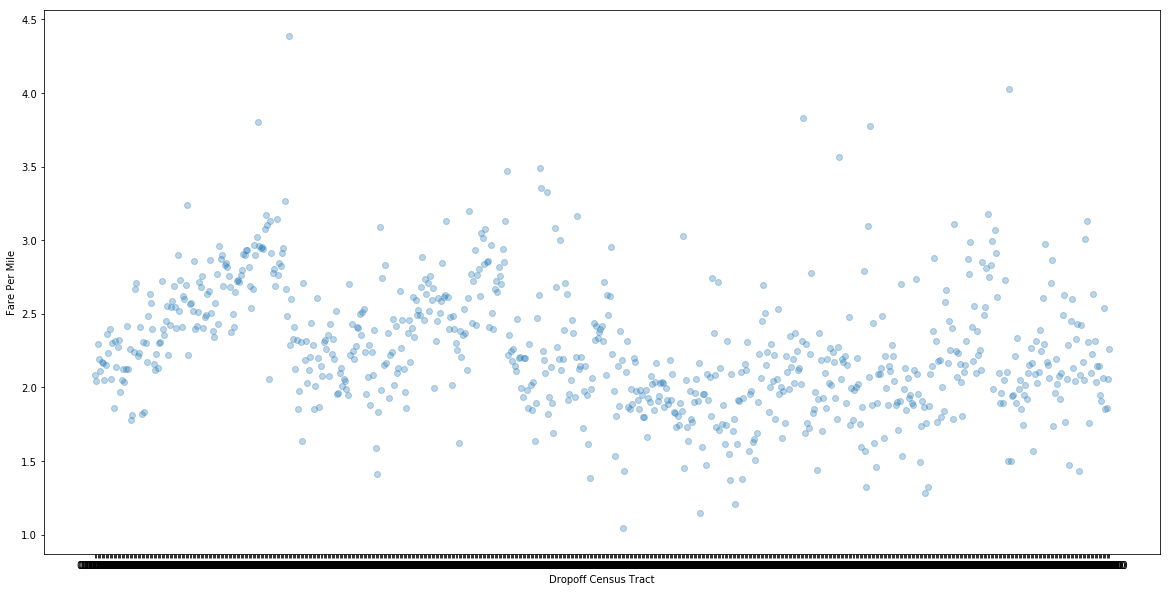

In [109]:
plt.scatter(x=dropoff_census_grouped['dropoff_census_tract'], y=dropoff_census_grouped['fare_per_mile'], alpha=0.30)
plt.xlabel('Dropoff Census Tract')
plt.ylabel('Fare Per Mile')
plt.show()

Mean Fare Per Mile For All Dropoff Census Tracks

In [110]:
total_mean = dropoff_census_grouped.fare_per_mile.mean()
total_mean

2.2619478705798666

Average Std. Dev. for All Dropoff Census Tracks

In [111]:
std_dev = pickup_census_grouped.fare_per_mile.std()
std_dev

0.43489722876961906

Dropoff Census Tracts whose Avg. Fare Per Mile is Outside of 2 Std. Dev. from Mean

In [117]:
mask = (dropoff_census_grouped['fare_per_mile'] > total_mean + 2*std_dev) | (dropoff_census_grouped['fare_per_mile'] < total_mean - 2*std_dev)
dropoff_tracts_outside_2_devs = dropoff_census_grouped[mask]
dropoff_tracts_outside_2_devs

dropoff_census_tract  fare_w_addl  trip_miles  fare_per_mile
69                050800    10.468871    3.230088       3.241048
122               071600    11.550235    3.039789       3.799684
128               080300     9.998330    3.152397       3.171660
136               081402    12.589623    3.999978       3.147423
142               081900     9.573447    2.931670       3.265527
145               090300     7.500000    1.708793       4.389063
280               240300    10.159248    3.179512       3.195222
308               243500     9.160181    2.639260       3.470739
333               260400     7.500000    2.147233       3.492868
334               260500     7.500000    2.236060       3.354114
338               260900    12.500000    3.757781       3.326431
361               300600    10.000000    3.160158       3.164399
370               301801    10.000000    7.209367       1.387084
395               351500    10.000000    9.584042       1.043401
453               440600    12.222222   10.644911       1.148175
475               490901    11.875000    8.675268       1.368834
479               491200    15.000000   12.421305       1.207603
484               500300    11.683333    8.487202       1.376582
530               610800     8.750000    2.285204       3.828980
557               640700    27.100000    7.595002       3.568136
577               670700    13.333333   10.058032       1.325640
580               671400     7.500000    1.985466       3.777452
621               711300     8.750000    6.828516       1.281391
623               711500    13.750000   10.382503       1.324343
668               832300     9.307077    2.929246       3.177295
684               834800     8.750000    2.174228       4.024417
742               842300     9.604581    3.066405       3.132196

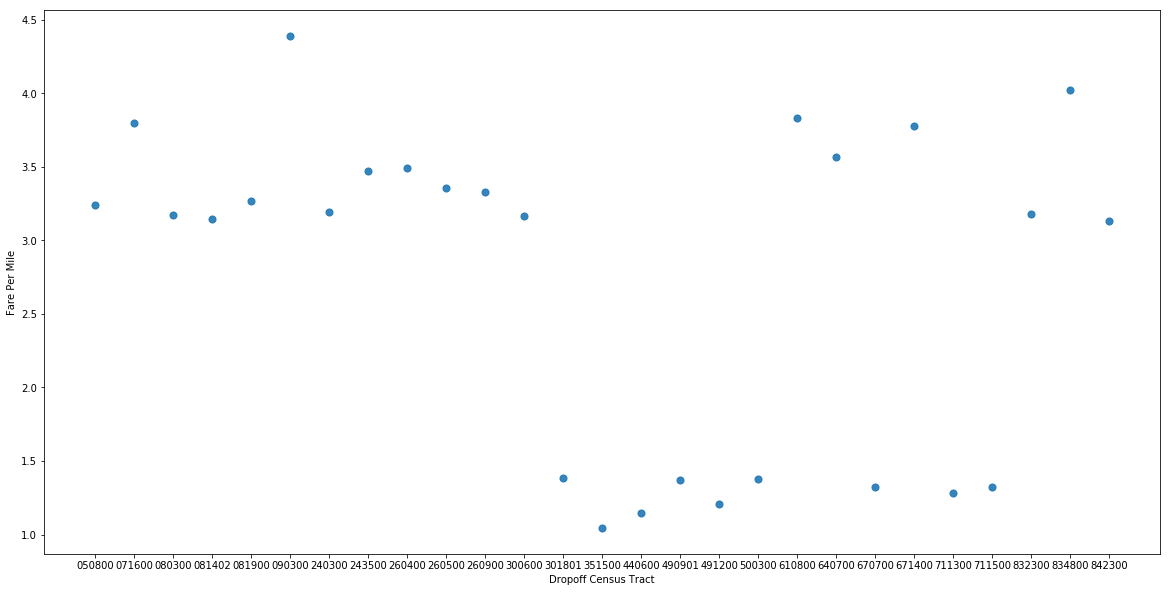

In [130]:
plt.scatter(x='dropoff_census_tract', y='fare_per_mile', data=dropoff_tracts_outside_2_devs, alpha=0.9, s=50)
plt.rcParams["figure.figsize"] = [10,10]
plt.xlabel('Dropoff Census Tract')
plt.ylabel('Fare Per Mile')
plt.show()

# Driver Dataset

API to get first 1,000 (max to download w/o loop) from drivers dataset & make pandas dataframe:

In [102]:
dr_response = requests.get('https://data.cityofchicago.org/resource/j6wf-834c.json').json()
dr_df = pd.DataFrame.from_dict(dr_response)

In [5]:
dr_df.columns

Index(['city', 'driver_start_month', 'month_reported', 'multiple_tnps',
       'number_of_trips', 'state', 'zip'],
      dtype='object')

See first 5 observations in dataset

In [6]:
dr_df.head(n=5)

city driver_start_month month_reported  multiple_tnps number_of_trips  \
0    Aurora            2015-12        2016-08          False             342   
1   Chicago            2017-02        2018-01           True             391   
2    Dolton            2015-03        2018-01           True             371   
3  Eilmette            2017-07        2017-09          False             251   
4   Chicago            2018-02        2018-06          False             332   

  state    zip  
0    IL  60505  
1    IL  60612  
2    IL  60419  
3    IL  60091  
4    IL  60606

Number of NaN/Null Values by Column

In [26]:
dr_df.isnull().sum(axis=0)

city                  40
driver_start_month     0
month_reported         0
multiple_tnps          0
number_of_trips        6
state                  0
zip                   40
dtype: int64

For longest value in each column:

In [27]:
longest_val = 0
for column in dr_df.columns:
    for val in dr_df[column].unique():
        if len(str(val)) > longest_val:
            longest_val = len(str(val))
    print(column, longest_val)

city 20
driver_start_month 20
month_reported 20
multiple_tnps 20
number_of_trips 20
state 20
zip 20


Earliest Driver Start Date in Set Pulled

In [16]:
dr_df.driver_start_month.min()

'2013-08'

Most Recent Driver Start Date in Set Pulled

In [18]:
dr_df.driver_start_month.max()

'2018-06'

Earliest Month Reported in Set Pulled

In [20]:
dr_df.month_reported.min()

'2015-03'

Latest Month Reported in Set Pulled

In [21]:
dr_df.month_reported.max()

'2018-06'

Percentage of Drivers in Dataset that Reported Multiple TNPS During this Time

In [118]:
(100 * dr_df[dr_df.multiple_tnps == True].shape[0])/dr_df.shape[0]

50.0

This is interesting that the data is not all most recently reported -- city must have another metric that we cannot see for sorting.

Percentage of Non-Chicago Drivers in Set

In [23]:
nonchi_dr = dr_df[dr_df['city']!= 'Chicago']

In [27]:
(100 * nonchi_dr.shape[0])/dr_df.shape[0]

77.6

Zipcodes of Drivers in Set

In [135]:
dr_df['zip'].unique()

array(['60505', '60612', '60419', '60091', '60606', '60632', '60402',
       '60016', '63020', '98023', '60137', '60409', '60172', '75287',
       '60133', nan, '60707', '60452', '60064', '60415', '60638', '60639',
       '60425', '60456', '60626', '60426', '60112', '60130', '60431',
       '60625', '60458', '60478', '46534', '60517', '60422', '60630',
       '60538', '60077', '60025', '60617', '60653', '60613', '60048',
       '60502', '60071', '60076', '46403', '60136', '60304', '20876',
       '60429', '60139', '60101', '46322', '60804', '60506', '60053',
       '60634', '60603', '60193', '98502', '60628', 'None', '52655',
       '60459', '60467', '60153', '60123', '60637', '60004', '60477',
       '60560', '60622', '60187', '63862', '60090', '60067', '52732',
       '60070', '60110', '60404', '60659', '60085', '60451', '33133',
       '60433', '60174', '60471', '60108', '60188', '60645', '60195',
       '60455', '98118', '60161', '60411', '60171', '60504', '60629',
       '60015', 

Find Invalid Zipcodes

In [66]:
invalid_zips = []
for zip_code in dr_df[dr_df['zip'].notnull()].zip.unique():
    if len(zip_code) < 5:
        invalid_zips.append(zip_code)

In [67]:
invalid_zips

['None', '6515', '6007', '2673']

Find Number of Invalid Zip Codes

In [69]:
num_invalid_zips = 0
for zip_code in invalid_zips:
    num_invalid_zips += dr_df[dr_df['zip'] == zip_code].shape[0]

In [70]:
num_invalid_zips

4

(double check)

In [60]:
dr_df['zip'].where(dr_df['zip'].str.len() < 5).count()

4

Drop Invalid & Null Zip Codes

In [77]:
cleaned_dr_df = dr_df[~dr_df['zip'].isin(invalid_zips)]
cleaned_dr_df = cleaned_dr_df[cleaned_dr_df['zip'].notnull()]

Driver Cities, Sorted by Count

In [148]:
grouped = dr_df.reset_index().groupby('city')['index'].count().reset_index()
grouped.rename(columns={'index': 'count'}, inplace=True)
grouped.sort_values('count', ascending=False)

city  count
59              Chicago    224
13               Aurora     17
311              Skokie     14
237          Naperville     13
114            Evanston     13
29          Bolingbrook     12
97          Des Plaines     11
174              Joliet     11
262            Palatine     10
327         Tinley Park      7
146        Hanover Park      6
287            Rockford      6
131                Gary      6
300          Schaumburg      6
41         Calumet City      6
352             Wheaton      6
151       Hickory Hills      6
357            Wilmette      6
5     Arlington Heights      6
150         Hazel Crest      6
28          Blue Island      5
175             Justice      5
253            Oak Park      5
259         Orland Park      5
242               Niles      5
191             Lansing      5
144             Hammond      5
73               Cicero      5
218        Melrose Park      5
353            Wheeling      5
..                  ...    ...
50              Chciago      1
162            Hometown      1
52           Chesterton      1
164             Houston      1
165             Huntley      1
166            Illinois      1
167             Indiana      1
168        Indianapolis      1
169         Indianpolis      1
170           Ingelside      1
171           Ingleside      1
172              Itasca      1
173        Jacksonville      1
51             Chebanse      1
176            Kankakee      1
48            Channahon      1
177             Kenosha      1
178           Key  West      1
179                Knox      1
181        La Grange Pk      1
182           La Orange      1
1                Alpine      1
184  Lake In The Hill S      1
49             Chciafgo      1
186        Lake Station      1
187          Lake Villa      1
188         Lake Zurich      1
189            Lakemore      1
190           Lancaster      1
183         Lake Forest      1

[366 rows x 2 columns]

# Vehicle Dataset

API to get first 1,000 (max to download w/o loop) from vehicles dataset & make pandas dataframe:

In [7]:
vehicle_response = requests.get('https://data.cityofchicago.org/resource/bc6b-sq4u.json').json()
vehicle_df = pd.DataFrame.from_dict(dr_response)

In [8]:
vehicle_df.columns

Index(['city', 'driver_start_month', 'month_reported', 'multiple_tnps',
       'number_of_trips', 'state', 'zip'],
      dtype='object')

See first 5 observations in dataset

In [9]:
vehicle_df.head(n=5)

city driver_start_month month_reported  multiple_tnps number_of_trips  \
0    Aurora            2015-12        2016-08          False             342   
1   Chicago            2017-02        2018-01           True             391   
2    Dolton            2015-03        2018-01           True             371   
3  Eilmette            2017-07        2017-09          False             251   
4   Chicago            2018-02        2018-06          False             332   

  state    zip  
0    IL  60505  
1    IL  60612  
2    IL  60419  
3    IL  60091  
4    IL  60606

Number of NaN/Null Values by Column

In [31]:
vehicle_df.isnull().sum(axis=0)

city                  40
driver_start_month     0
month_reported         0
multiple_tnps          0
number_of_trips        6
state                  0
zip                   40
dtype: int64

For longest value in each column:

In [32]:
longest_val = 0
for column in vehicle_df.columns:
    for val in vehicle_df[column].unique():
        if len(str(val)) > longest_val:
            longest_val = len(str(val))
    print(column, longest_val)

city 20
driver_start_month 20
month_reported 20
multiple_tnps 20
number_of_trips 20
state 20
zip 20
